# Actividad Grupal: Evaluación de la segmentación


### Objetivos

El objetivo de este trabajo es aprender a construir y evaluar el rendimiento de uno o más segmentadores. Esta actividad permitirá consolidar los conceptos sobre segmentación de imágenes aprendidos.


#### =============================================
#### 1. IMPORTAR LIBRERÍAS
#### =============================================

In [4]:
!pip install scikit-image
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
import pandas as pd
from skimage.filters import threshold_otsu
import os


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 416.1 kB/s eta 0:00:30
   ------ --------------------------------- 2.1/12.9 MB 2.0 MB/s eta 0:00:06
   ------------- -------------------------- 4.2/12.9 MB 3.5 MB/s eta 0:00:03
   -------------- ------------------------- 4.7/12.9 MB 3.3 MB/s eta 0:00:03
   ---------------- ----------------------- 5.2/12.9 MB 3.3 MB/s eta 0:00:03
   ----------------- ---------------------- 5.8/12.9 MB 3.2 MB/s eta 0:00:03
   ------------------ --------------------- 6.0/12.9 MB 3.1 MB/s eta 0:00:03
   -------------------- ------------------- 6.6/12.9 MB 3.0 MB/s eta 0:00:03
   --------------------- ------------------ 6.8/12.9 MB 2.8 MB/s eta 0:00:03
   --------------------- 

#### =============================================
#### 2. CARGAR MODELO DEEPLABV3
#### =============================================

In [5]:
#### DeepLabv3 con backbone ResNet101 preentrenado en COCO
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

C:\Users\atova\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\atova\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\atova/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth


100.0%


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### =============================================
#### 3. TRANSFORMACIONES DE PREPROCESAMIENTO
#### =============================================

In [6]:
# transformación
preprocess = transforms.Compose([
    transforms.Resize((520, 520)),  #### Redimensionar a tamaño de entrada del modelo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#### =============================================
#### 4. FUNCIONES AUXILIARES
#### =============================================

In [31]:
def segment_person_deeplab(image_path):
    """
    Segmenta la clase 'person' usando DeepLabv3.
    Retorna la imagen original y la máscara binaria.
    """
    img = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)["out"][0]
    pred = output.argmax(0).byte().cpu().numpy()

    #### Clase 15 = 'person' en COCO
    person_mask = (pred == 15).astype(np.uint8)
    return img, person_mask

def segment_person_otsu(image_path):
    """
    Segmentación simple usando umbralización de Otsu.
    Trabaja sobre imagen en escala de grises.
    """
    img = Image.open(image_path).convert("L").resize((520, 520))
    img_arr = np.array(img)
    thresh = threshold_otsu(img_arr)
    mask = (img_arr > thresh).astype(np.uint8)
    return mask

    #### Métricas de evaluación
def iou_score(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0

def dice_score(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    return (2 * intersection) / (pred_mask.sum() + true_mask.sum()) if (pred_mask.sum() + true_mask.sum()) > 0 else 0

def pixel_accuracy(pred_mask, true_mask):
    return (pred_mask == true_mask).sum() / pred_mask.size

def precision_score(pred_mask, true_mask):
    TP = np.logical_and(pred_mask == 1, true_mask == 1).sum()
    FP = np.logical_and(pred_mask == 1, true_mask == 0).sum()
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def recall_score(pred_mask, true_mask):
    TP = np.logical_and(pred_mask == 1, true_mask == 1).sum()
    FN = np.logical_and(pred_mask == 0, true_mask == 1).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def f1_score(pred_mask, true_mask):
    prec = precision_score(pred_mask, true_mask)
    rec = recall_score(pred_mask, true_mask)
    return (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

#### =============================================
#### 5. DEFINIR RUTAS DE IMÁGENES Y MÁSCARAS
#### =============================================

In [32]:
imagenes = ["./images/image1.jpg", "./images/image2.jpg", "./images/image3.jpg"]
mascaras_gt = ["./masks/mask_image1.jpg", "./masks/mask_image2.jpg", "./masks/mask_image3.jpg"]

#### =============================================
#### 6. PROCESAR Y EVALUAR SEGMENTADORES
#### =============================================

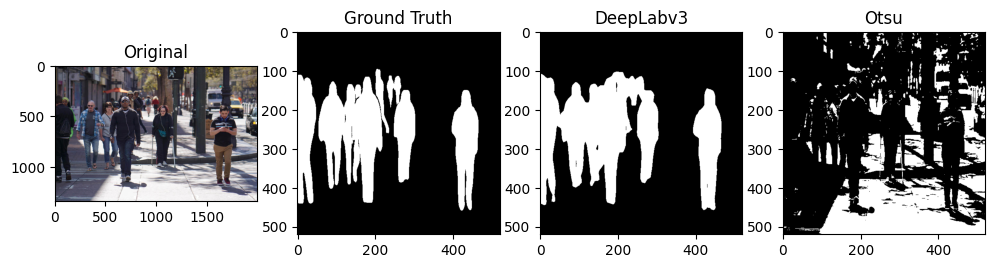

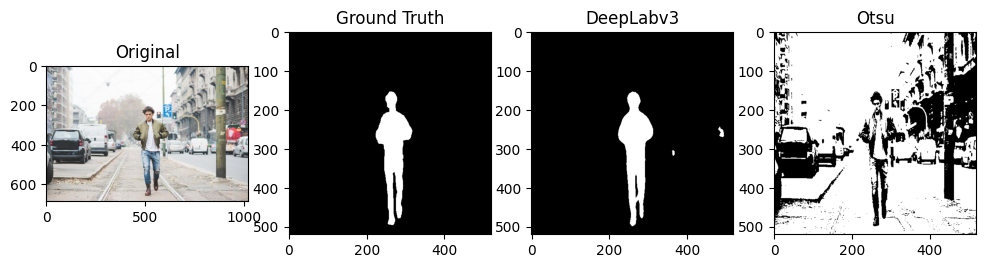

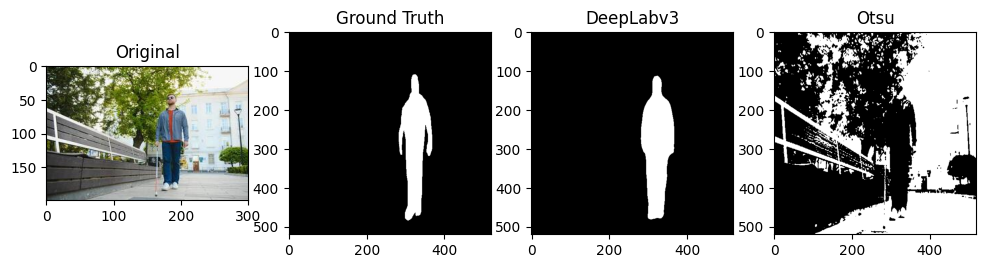

In [33]:
resultados = []

for img_path, mask_path in zip(imagenes, mascaras_gt):
    #### --- DeepLabv3 ---
    img, pred_mask_dl = segment_person_deeplab(img_path)

    #### --- Otsu ---
    pred_mask_otsu = segment_person_otsu(img_path)

    #### --- Ground Truth ---
    true_mask = np.array(Image.open(mask_path).convert("L").resize((520, 520))) > 127

    #### --- Métricas DeepLabv3 ---
    iou_dl = iou_score(pred_mask_dl, true_mask)
    dice_dl = dice_score(pred_mask_dl, true_mask)
    acc_dl = pixel_accuracy(pred_mask_dl, true_mask)
    prec_dl = precision_score(pred_mask_dl, true_mask)
    rec_dl = recall_score(pred_mask_dl, true_mask)
    f1_dl = f1_score(pred_mask_dl, true_mask)

    #### --- Métricas Otsu ---
    iou_otsu = iou_score(pred_mask_otsu, true_mask)
    dice_otsu = dice_score(pred_mask_otsu, true_mask)
    acc_otsu = pixel_accuracy(pred_mask_otsu, true_mask)
    prec_otsu = precision_score(pred_mask_otsu, true_mask)
    rec_otsu = recall_score(pred_mask_otsu, true_mask)
    f1_otsu = f1_score(pred_mask_otsu, true_mask)
    #### --- Guardar resultados ---
    resultados.append({
        "Imagen": os.path.basename(img_path),
        "IoU DeepLabv3": round(iou_dl, 3), "Dice DeepLabv3": round(dice_dl, 3), "Acc DeepLabv3": round(acc_dl, 3),
        "Prec DeepLabv3": round(prec_dl, 3), "Recall DeepLabv3": round(rec_dl, 3), "F1 DeepLabv3": round(f1_dl, 3),
        "IoU Otsu": round(iou_otsu, 3), "Dice Otsu": round(dice_otsu, 3), "Acc Otsu": round(acc_otsu, 3),
        "Prec Otsu": round(prec_otsu, 3), "Recall Otsu": round(rec_otsu, 3), "F1 Otsu": round(f1_otsu, 3)
    })

    #### --- Visualizar resultados ---
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(1,4,2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Ground Truth")

    plt.subplot(1,4,3)
    plt.imshow(pred_mask_dl, cmap="gray")
    plt.title("DeepLabv3")

    plt.subplot(1,4,4)
    plt.imshow(pred_mask_otsu, cmap="gray")
    plt.title("Otsu")
    plt.show()


#### =============================================
#### 7. TABLA DE RESULTADOS
#### =============================================


In [34]:
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

       Imagen  IoU DeepLabv3  Dice DeepLabv3  Acc DeepLabv3  Prec DeepLabv3  \
0  image1.jpg          0.899           0.947          0.971           0.916   
1  image2.jpg          0.894           0.944          0.994           0.920   
2  image3.jpg          0.830           0.907          0.987           0.842   

   Recall DeepLabv3  F1 DeepLabv3  IoU Otsu  Dice Otsu  Acc Otsu  Prec Otsu  \
0             0.980         0.947     0.023      0.046     0.491      0.044   
1             0.969         0.944     0.031      0.059     0.251      0.032   
2             0.983         0.907     0.016      0.031     0.487      0.017   

   Recall Otsu  F1 Otsu  
0        0.047    0.046  
1        0.436    0.059  
2        0.127    0.031  


### 3.4 Modelo 4: DeepLabv3

<!-- COMENTARIO PARA COMPAÑERO 1:
Aquí debes agregar tu modelo de segmentación
- Métodos tradicionales (Watershed, Region Growing)

Por favor incluye:
1. Justificación de por qué elegiste este modelo
2. Arquitectura técnica o algoritmo
3. Parámetros de configuración
4. Flujo de procesamiento
5. Ventajas y limitaciones esperadas
-->

#### Justificación del Modelo

El modelo DeepLabv3 es una de las arquitecturas más reconocidas en el campo de la segmentación semántica, propuesta por Google Research.

* DeepLabv3 utiliza **Atrous Convolution** (o convolución dilatada) para ampliar el campo receptivo de la red sin perder resolución espacial, lo que le permite capturar tanto detalles locales como contexto global. Además, incorpora el módulo **Atrous Spatial Pyramid Pooling (ASPP)**, que aplica convoluciones dilatadas con diferentes tasas para detectar objetos a múltiples escalas, algo crucial cuando las personas aparecen en distintos tamaños dentro de las imágenes.

* Ofrece un buen compromiso entre precisión y tiempo de inferencia. Aunque existen arquitecturas más ligeras, estas suelen sacrificar calidad en la segmentación, mientras que modelos más pesados como Mask R‑CNN requieren mayor capacidad de cómputo y están orientados a segmentación de instancias. En este contexto, DeepLabv3 permite procesar imágenes con una resolución razonable (520×520 píxeles) y obtener resultados de alta calidad en pocos segundos.


#### Arquitectura/Algoritmo
##### 1. Descripción general de DeepLabv3
DeepLabv3 es una red de segmentación semántica propuesta por Google Research. Está diseñada para mejorar la detección de objetos y sus bordes, capturando información contextual a múltiples escalas mediante convoluciones dilatadas (*Atrous Convolutions*).

La arquitectura tiene tres componentes clave:

1. **Backbone convolucional (ResNet‑101)**  
   - Encargado de extraer características jerárquicas de la imagen.  
   - Utiliza *residual connections* que facilitan el entrenamiento de redes profundas.  
   - Se aplica *Atrous Convolution* en las últimas capas para ampliar el campo receptivo sin reducir la resolución espacial.

2. **Atrous Spatial Pyramid Pooling (ASPP)**  
   - Módulo que aplica convoluciones dilatadas con diferentes tasas de dilatación.  
   - Permite capturar información a distintas escalas, crucial para objetos de diferentes tamaños.  
   - Incluye una rama de *global average pooling* para incorporar contexto global.

3. **Decoder / Clasificación por píxel**  
   - Toma las características procesadas por el ASPP y las proyecta a un mapa de etiquetas por píxel.  
   - En el caso del modelo preentrenado en COCO, produce un tensor de forma *(num_clases × alto × ancho)*, donde `num_clases = 21`.

##### 2. Algoritmo de procesamiento
El flujo de inferencia de DeepLabv3 puede describirse así:

1. **Entrada**: Imagen RGB normalizada y redimensionada a 520×520 píxeles.
2. **Extracción de características**: La imagen pasa por el backbone ResNet‑101 con convoluciones dilatadas.
3. **ASPP**: Se aplican convoluciones dilatadas con diferentes tasas y *global pooling* para capturar contexto multiescala.
4. **Fusión de características**: Las salidas de ASPP se concatenan y se proyectan a la dimensión de clases mediante una capa convolucional 1×1.
5. **Predicción por píxel**: Se obtiene un mapa de probabilidad por clase para cada píxel.
6. **Selección de clase**: Se toma la clase con mayor probabilidad en cada píxel (en este caso, se filtra la clase *person* con id = 15 en COCO).
7. **Salida**: Máscara binaria de la clase objetivo.

##### 3. Ventajas de la arquitectura
- Captura información global y local gracias al ASPP.
- Mantiene mayor resolución en la segmentación gracias al uso de *Atrous Convolution*.
- Preentrenado en COCO, lo que permite obtener buenos resultados incluso con pocos datos propios.
- Disponible en bibliotecas estándar como Torchvision, garantizando reproducibilidad y facilidad de implementación.

#### Parámetros de Configuración
| Parámetro | Valor | Justificación |
|---|---|---|
| Modelo | DeepLabv3_ResNet101 (preentrenado en COCO) | Backbone ResNet101 profundo que captura mejor las características y contexto de la imagen. Entrenado en COCO, que incluye la clase person. |
| Tamaño de entrada | 520 × 520 píxeles | Tamaño compatible con la implementación oficial en Torchvision, balancea detalle y costo computacional. |
| Normalización | Media = [0.485, 0.456, 0.406], Desv. Est. = [0.229, 0.224, 0.225] | Valores estándar para modelos preentrenados en ImageNet (base de ResNet101). |
| Métricas de evaluación | IoU, Dice, Pixel Accuracy | Métricas estándar en segmentación para comparar predicciones y ground truth. |


#### Flujo de Procesamiento
1. **Carga de imágenes y máscaras de *ground truth***  
   - Se cargan desde almacenamiento local las imágenes originales y sus máscaras correspondientes.  
   - Las máscaras se convierten a binario (0 = fondo, 1 = persona) y se redimensionan a 520×520 píxeles para coincidir con la salida del modelo.

2. **Preprocesamiento de imágenes**  
   - Redimensionado a 520×520 píxeles.  
   - Conversión a tensor de PyTorch.  
   - Normalización con medias y desviaciones estándar de ImageNet.

3. **Segmentación con DeepLabv3**  
   - Se pasa la imagen preprocesada al modelo.  
   - El modelo produce un mapa de etiquetas por píxel (21 clases para COCO).  
   - Se filtra la clase *person* (id = 15) para generar la máscara binaria.

4. **Segmentación con método comparativo (Otsu)**  
   - Conversión de la imagen a escala de grises.  
   - Cálculo del umbral óptimo mediante el método de Otsu.  
   - Generación de máscara binaria.

5. **Evaluación de resultados**  
   - Comparación de cada máscara predicha (DeepLabv3 y Otsu) contra el *ground truth* usando métricas:
     - IoU (*Intersection over Union*)
     - Dice
     - Exactitud por píxel (*Pixel Accuracy*)
   - Registro de métricas en una tabla comparativa.

6. **Visualización**  
   - Se muestran en pantalla para cada imagen:
     - Imagen original
     - Ground truth
     - Máscara predicha por DeepLabv3
     - Máscara predicha por Otsu  
   - Se presenta una tabla final con las métricas de todas las imágenes.



| NO | Imagen | IoU DeepLabv3 | Dice DeepLabv3 | Acc DeepLabv3 | IoU Otsu |
|---|---|---|---|---|---|     
| 0 | image1.jpg | 0.899 | 0.947 | 0.971 | 0.023 |   
| 1 | image2.jpg | 0.894 | 0.944 | 0.994 | 0.031 | 
| 2 | image3.jpg | 0.830 | 0.907 | 0.987 | 0.016 |

